In [6]:
import matplotlib.pyplot as plt

%matplotlib inline

import numpy as np
import healpy as hp
from matplotlib import cm
planck = hp.read_map('/home/matthew/Downloads/HFI_CompMap_ThermalDustModel_2048_R1.20.fits')

In [33]:
from astropy.coordinates import SkyCoord  # High-level coordinates
from astropy.coordinates import ICRS, Galactic, FK4, FK5  # Low-level frames
from astropy.coordinates import Angle, Latitude, Longitude  # Angles
import astropy.units as u

In [4]:
def compute_ang_err(ra, dec, sigma):
    r''' Compute circular uncertainty contour around point credit: https://user-web.icecube.wisc.edu/~icecube-bootcamp/bootcamp2019/advanced_plotting/exercise/advanced_plotting.ipynb
    on a healpix map.
    Parameters:
    -----------
    ra: float
        Right ascension of center point in radians
    dec: float 
        declination of center point in radians
    sigma:
        Angular uncertainty (radius of circle to draw 
        around (ra,dec)) in radians
    Returns:
    --------
    Theta: array
        theta values of contour in radians
    Phi: array
        phi values of contour in radians
    '''

    dec = np.pi/2 - dec
    
    delta = sigma
    step = 1. / np.sin(delta) / 20.
    bins = int(360./step)
    Theta = np.zeros(bins+1, dtype=np.double)
    Phi = np.zeros(bins+1, dtype=np.double)
    
    # define the contour
    for j in range(0,bins) :
            phi = j*step/180.*np.pi
            vx = np.cos(phi)*np.sin(ra)*np.sin(delta) + np.cos(ra)*(np.cos(delta)*np.sin(dec) + np.cos(dec)*np.sin(delta)*np.sin(phi))
            vy = np.cos(delta)*np.sin(dec)*np.sin(ra) + np.sin(delta)*(-np.cos(ra)*np.cos(phi) + np.cos(dec)*np.sin(ra)*np.sin(phi))
            vz = np.cos(dec)*np.cos(delta) - np.sin(dec)*np.sin(delta)*np.sin(phi)
            
            idx = hp.vec2pix(nside, vx, vy, vz)
            DEC, RA = hp.pix2ang(nside, idx)
            
            Theta[j] = DEC
            Phi[j] = RA
    Theta[bins] = Theta[0]
    Phi[bins] = Phi[0]

    return Theta, Phi

/tmp/ipykernel_112495/3837161213.py:16: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros(hp.nside2npix(nside), dtype=np.bool)
/tmp/ipykernel_112495/3837161213.py:26: RuntimeWarning: overflow encountered in true_divide
  hp.cartview(planck_masked.filled()/1.18e-26,fig=fig,title=r'$N_H$',norm='linear',lonra=[l-xsize,l+xsize],latra=[b-ysize,b+ysize],unit='cm$^{-2}$',cmap=cmap,bgcolor='k')
76.52732423332189 104.7926757666781 112.73638653957912 141.00361346042087


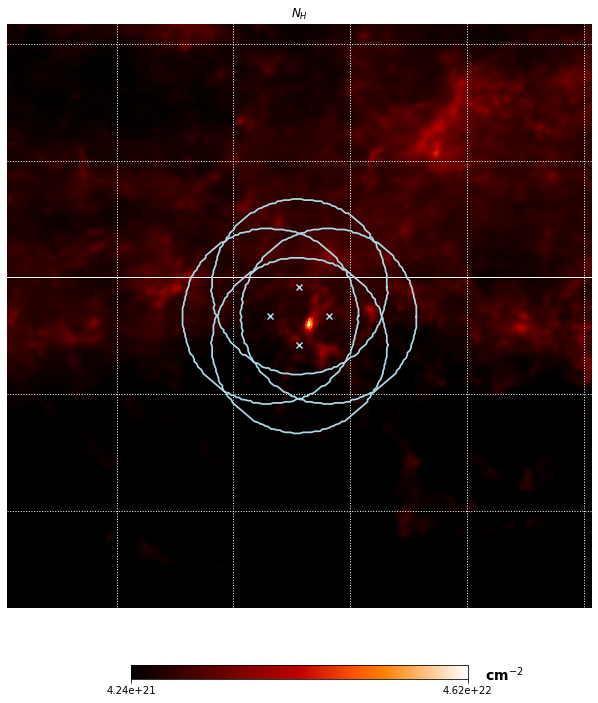

In [90]:
l= 126.87
b=-0.66 

coord = SkyCoord(l*u.deg,b*u.deg, frame=Galactic)
coord_ICRS=coord.transform_to('icrs')

xsize=5
ysize=5
cmap = cm.gist_heat
#cmap.set_under("k")
nside = hp.pixelfunc.get_nside(planck)
#2e-5

planck_masked = hp.ma(planck)
mask = np.zeros(hp.nside2npix(nside), dtype=np.bool)
mask[planck>5e-5]=1
planck_masked.mask = np.logical_not(mask)


fig = plt.figure(figsize=(11,11))

#ax.set_facecolor('black')


hp.cartview(planck_masked.filled()/1.18e-26,fig=fig,title=r'$N_H$',norm='linear',lonra=[l-xsize,l+xsize],latra=[b-ysize,b+ysize],unit='cm$^{-2}$',cmap=cmap,bgcolor='k')
hp.graticule(dpar=2,dmer=2,color='white')


def plotveri(coord,sigma = 1.5):
    hp.projscatter(coord.l,coord.b,lonlat='True',c='lightblue',marker='x',label='VERITAS Proposed Pointing')
    my_contour = compute_ang_err(coord.l.rad,coord.b.rad,np.deg2rad(sigma))
    hp.projplot(my_contour[0], my_contour[1], linewidth=1.75, color="lightblue",
                linestyle='solid',coord='C')
def plotwobble(coord,wobble=0.5):
    
    plotveri(coord.spherical_offsets_by(0*u.deg, wobble*u.deg))
    
    plotveri(coord.spherical_offsets_by(0*u.deg, -wobble*u.deg))
    plotveri(coord.spherical_offsets_by(wobble*u.deg, 0.0*u.deg))
    plotveri(coord.spherical_offsets_by(-wobble*u.deg, 0.0*u.deg))
plotwobble(coord,wobble=0.5)
#plt.text(174.3852 ,-13.4312,'l (degrees)',ha="center", va="center")
#plt.text('b (degrees)',ha="center", va="center")
#plt.legend(loc=1,bbox_to_anchor=(0.99,0.99),prop={'size': 14})
plt.show()